In [1]:
import sys
sys.path.insert(0, "../backend")

import backtrader as bt
import pandas as pd
from portfolio_model import PortfolioModels

In [2]:
datafile = '../data/data.h5'

In [3]:
class RobinhoodHistory(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.df_ord = pd.read_hdf(datafile, 'orders')
        self.pf = pd.read_hdf(datafile, 'market')
        self.symbols = list(self.pf.minor_axis.values)
        self.df_ord['dt'] = self.df_ord['date'].apply(lambda x: x.to_pydatetime().date())

    def next(self):
        # Simply log the closing price of the series from the reference
        dt = self.datas[0].datetime.date(0)
        if dt in self.df_ord['dt'].values:
            orders = self.df_ord[self.df_ord['dt'] == dt]
            order = orders.iloc[0]
            symbol = order['symbol']
            datanum = self.symbols.index(order['symbol'])
            price = order['average_price']
            size = order['signed_size']
            self.buy(
                data=self.datas[datanum],
                price=price,
                size=size)
            self.log('BUY CREATE {}/{}: {} @ {}'.format(symbol, datanum, size, price))

In [11]:
mkt.major_axis.min()

Timestamp('2016-06-08 00:00:00')

2016-06-08, BUY CREATE VTI/3: 3 @ 108.5999
2016-06-13, BUY CREATE BND/0: 450 @ 83.5399
2016-06-15, BUY CREATE VEA/1: 2 @ 34.8499
2016-06-28, BUY CREATE VTI/3: 1 @ 103.2
2016-07-05, BUY CREATE VTI/3: 9 @ 106.54
2016-07-12, BUY CREATE BND/0: 50 @ 84.51
2016-07-14, BUY CREATE VIG/2: 54 @ 85.5
2016-08-08, BUY CREATE BND/0: 1 @ 83.98
2016-09-12, BUY CREATE VTI/3: 1 @ 110.99
2016-09-15, BUY CREATE VIG/2: 11 @ 83.03
2016-09-20, BUY CREATE VTI/3: 2 @ 110.01
2016-09-21, BUY CREATE BND/0: 50 @ 83.56
2016-10-10, BUY CREATE VWO/4: -3 @ 38.2501


<IPython.core.display.Javascript object>


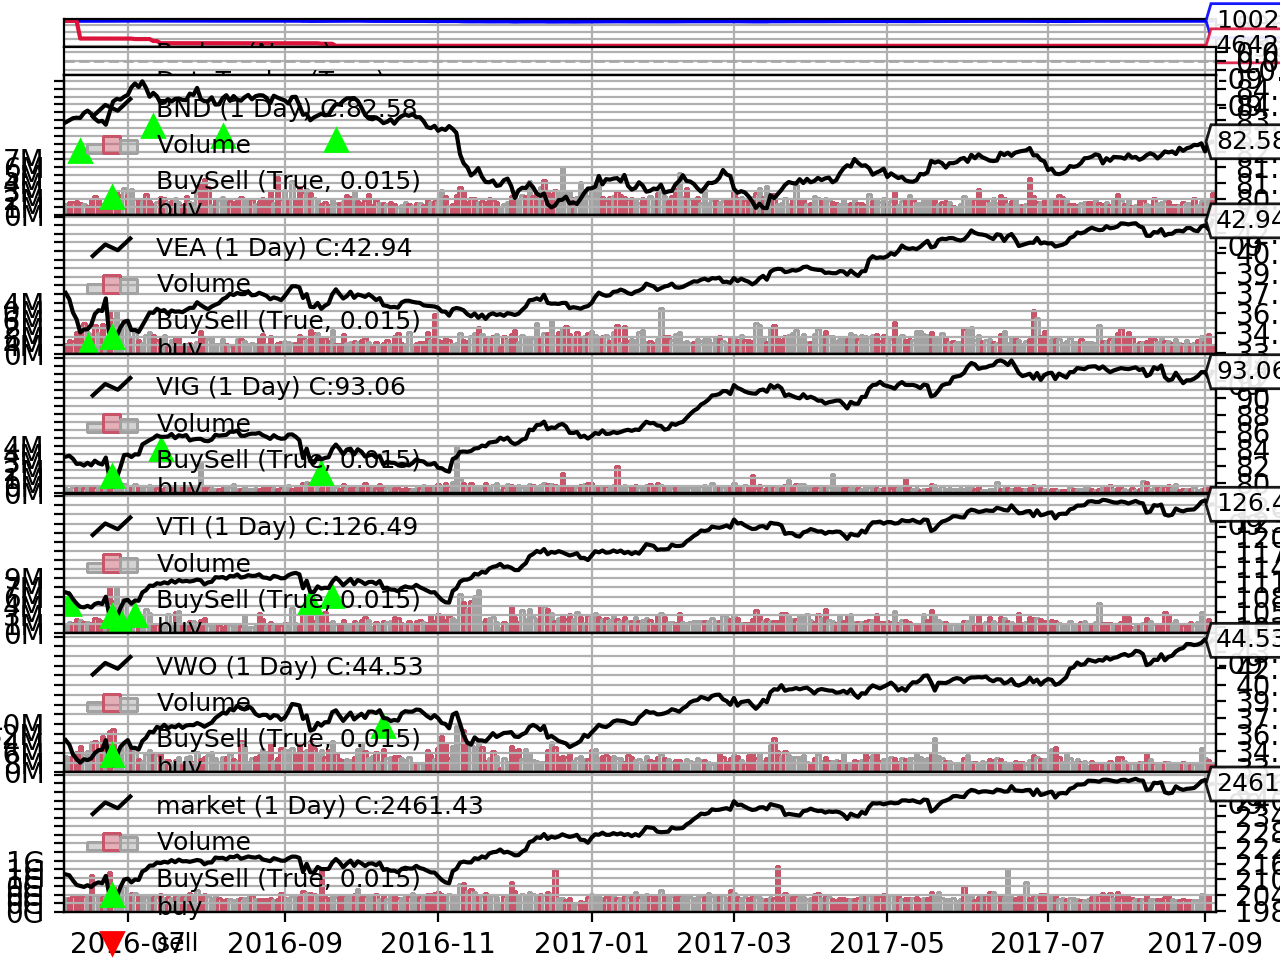

In [9]:
cerebro = bt.Cerebro()
cerebro.addstrategy(RobinhoodHistory)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

mkt = pd.read_hdf(datafile,'market')
mkt["OpenInterest"] = 0

is_first = True

for key in mkt.minor_axis:
    data = bt.feeds.PandasData(dataname=mkt.minor_xs(key), name=key)
    cerebro.adddata(data)

cerebro.broker.setcash(100000.0)

results = cerebro.run()
cerebro.plot()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()